In [122]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.model_selection import train_test_split
from kernel import Evaluator
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [2]:
print('Loading Dataset...')
train = pd.read_csv("train.tsv", sep='\t')
test = pd.read_csv("test.tsv", sep='\t')
print('Dataset loaded!...')

Loading Dataset...
Dataset loaded!...


In [3]:
X = train.loc[:, train.columns!='price']
y = train.loc[:, ['price']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Now we're going to create a simple classifier which has only item_condition_id and shipping. Train it, then test it from there. And then look at the score.

In [103]:
S_train = X_train.loc[:, ['item_condition_id', 'shipping']]
S_test = X_test.loc[:, ['item_condition_id', 'shipping']]

In [104]:
# Fit Regressor to the Data
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)

In [105]:
regr_1.fit(S_train, np.log1p(y_train))
regr_2.fit(S_train, np.log1p(y_train))

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [106]:
# Find the feature importances of these regressors
print(regr_1.feature_importances_)
print(regr_2.feature_importances_)

[ 0.09851607  0.90148393]
[ 0.11056015  0.88943985]


In [107]:
train_predict_1 = regr_1.predict(S_train)
train_predict_2 = regr_2.predict(S_train)
ev_train = Evaluator(y_train.values)
train_score_1 = ev_train.rmsle_loop(np.expm1(train_predict_1))
train_score_2 = ev_train.rmsle_loop(np.expm1(train_predict_2))
print(train_score_1, train_score_2)

0.7266657151210284 0.7263595037821374


In [108]:
y_1 = regr_1.predict(S_test)
y_2 = regr_2.predict(S_test)

In [109]:
ev = Evaluator(y_test.values)
# print(dir(ev))
score = ev.rmsle_loop(np.expm1(y_1))
score_2 = ev.rmsle_loop(np.expm1(y_2))
print(score, score_2)

0.7274138514434257 0.7271204069294144


We got an evaluation score of 0.7997 for the regressor of `max_depth` 2 and that of 0.7993 for the regressor of `max_depth` of 5. Not bad. <br>Now let's try to explore the dataset

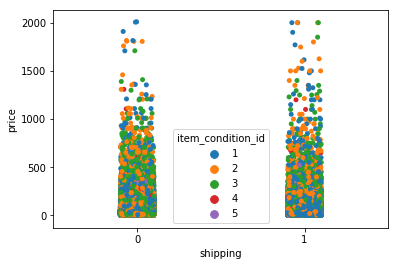

In [30]:
iris = sns.load_dataset('iris')
# Plot relationship between Shipping and Price, and Jitter it.
sns.stripplot(x=S_train['shipping'], y=y_train['price'], hue=S_train['item_condition_id'], jitter=True)

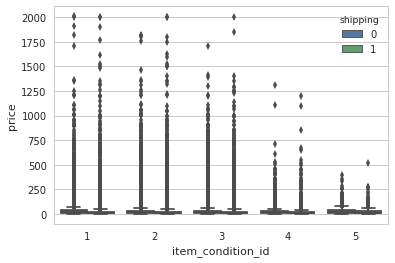

In [124]:
# Plot relationship between Item Condition and Price, and Jitter it.
# sns.stripplot(x=S_train['item_condition_id'], y=y_train['price'], hue=S_train['shipping'], jitter=True)
sns.boxplot(x=S_train['item_condition_id'], y=np.log1py_train['price'], hue=S_train['shipping'])

Seems like the shipping feature is very informative, but the `item_condition_id` feature isn't as informative. Let's try to work on changing the `item_condition_id` feature. First, let's produce a histogram of this particular feature.

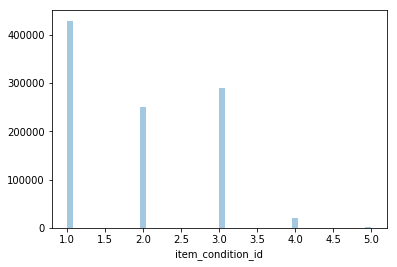

In [44]:
sns.distplot(S_train['item_condition_id'], kde=False)

From the graph we can clearly see that the `item_condition_id` for 5 is way too little, and this might affect the Regressor. However, we don't even know if there are other `item_condition_id`s. Let's try to obtain the unique values of this variable from the whole dataset.

In [53]:
ici_unique = X_train['item_condition_id'].unique()
print(X_train['item_condition_id'].value_counts(normalize='True'))
print(ici_unique)

1    0.432178
3    0.291495
2    0.253264
4    0.021505
5    0.001557
Name: item_condition_id, dtype: float64
[1 3 4 2 5]


Great, we have all of the unique `item_condition_id`, and it's from 1 to 5. Now, I really want to see the percentage of these values. Let's find a way to obtain these percentages.

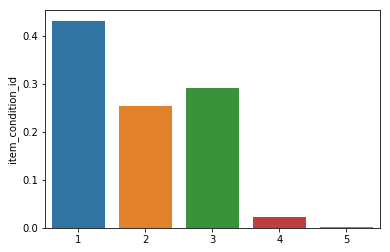

In [68]:
sns.barplot(x=S_train['item_condition_id'].value_counts(normalize='True').index, 
            y=S_train['item_condition_id'].value_counts(normalize='True'))

Plot another graph, to clearly show that products with shipping and item condition of 1 dominate the dataset.

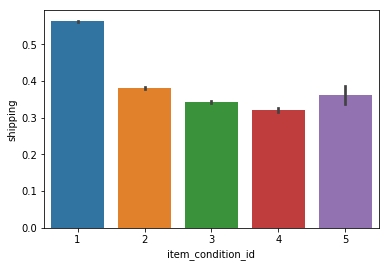

In [69]:
sns.barplot(x="item_condition_id", y="shipping", data=S_train)

Pheww, finally did it. Great job. Now, you can clearly see that both 4 and 5 are less than 5 percent of the total count. So, we combine them together.

In [117]:
def f(row):
    if row['item_condition_id'] in [3,4,5]:
        val = 3
    elif row['item_condition_id'] in [1,2]:
        val = row['item_condition_id']
    return val
S_train['n_condition'] = S_train.apply(f,axis=1)
S_test['n_condition'] = S_test.apply(f,axis=1)

In [118]:
print(S_train['n_condition'].unique())
print(S_train['n_condition'].value_counts(normalize='True'))
# Delete the item_conditions_id column
new_s_train = S_train.drop('item_condition_id', axis=1)
new_s_test = S_test.drop('item_condition_id', axis=1)
print(new_s_train.columns)
print(new_s_test.columns)

[1 3 2]
1    0.432178
3    0.314557
2    0.253264
Name: n_condition, dtype: float64
Index(['shipping', 'n_condition'], dtype='object')
Index(['shipping', 'n_condition'], dtype='object')


In [119]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(new_s_train, np.log1p(y_train))
regr_2.fit(new_s_train, np.log1p(y_train))

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [120]:
print(regr_1.feature_importances_)
print(regr_2.feature_importances_)

[ 0.90148393  0.09851607]
[ 0.89405203  0.10594797]


In [121]:
train_predict_1 = regr_1.predict(new_s_train)
train_predict_2 = regr_2.predict(new_s_train)
ev_train = Evaluator(y_train.values)
train_score_1 = ev_train.rmsle_loop(np.expm1(train_predict_1))
train_score_2 = ev_train.rmsle_loop(np.expm1(train_predict_2))
print(train_score_1, train_score_2)

0.7266657151210273 0.7264777548685666


In [125]:
y_1 = regr_1.predict(new_s_test)
y_2 = regr_2.predict(new_s_test)

In [126]:
ev = Evaluator(y_test.values)
# print(dir(ev))
score = ev.rmsle_loop(np.expm1(y_1))
score_2 = ev.rmsle_loop(np.expm1(y_2))
print(score, score_2)

0.7274138514434252 0.7272317976363915


There was no change in score, it stayed the same even with the `item_condition_id` becoming 4. How about we make it to become 3?